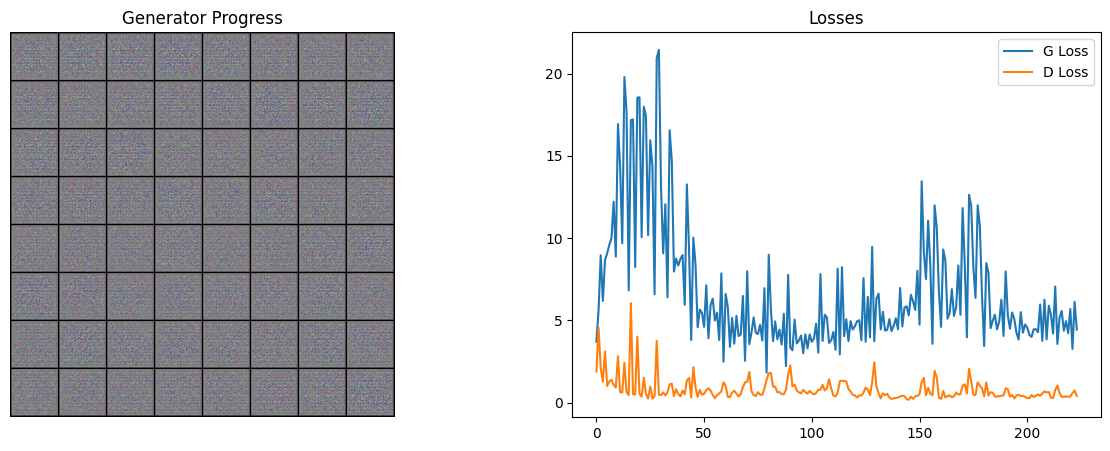

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets import load_dataset, Image
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

# Set random seed for reproducibility
manualSeed = 999
print("Random Seed: ", manualSeed)
torch.manual_seed(manualSeed)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
dataroot = "D:\\Diffusion\\Training\\_datasets\\dreamweaver\\cont\\backbend-chest-side"  # Your dataset path
workers = 0  # Set to 0 to avoid DataLoader worker errors
batch_size = 128
image_size = 64  # All images will be resized to this size
num_channels = 3  # Number of channels in the training images (3 for RGB)
latent_dim = 100  # Size of z latent vector (i.e., size of generator input)
num_epochs = 500
lr = 0.0003  # Learning rate for optimizers
beta1 = 0.5  # Beta1 hyperparam for Adam optimizers
ngpu = 1  # Number of GPUs available

# Transformations
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load dataset using load_dataset
dataset = load_dataset("imagefolder", data_dir=dataroot, split="train")

# Ensure images are loaded as PIL Images
dataset = dataset.cast_column("image", Image())

# Apply transformations using set_transform
def preprocess(batch):
    images = []
    for image in batch["image"]:
        try:
            img = transform(image.convert("RGB"))
        except Exception as e:
            print(f"Error processing image: {e}")
            img = torch.zeros(3, image_size, image_size)  # Placeholder tensor
        images.append(img)
    return {"image": images}

dataset.set_transform(preprocess)

# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Initialize weights function
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Code
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # State size: (512) x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # State size: (256) x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # State size: (128) x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # State size: (64) x 32 x 32
            nn.ConvTranspose2d(64, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output size: (num_channels) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# Create the generator
netG = Generator(ngpu).to(device)
netG.apply(weights_init)

# Discriminator Code
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(num_channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (64) x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (128) x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (256) x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # State size: (512) x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # Output: Scalar probability
        )

    def forward(self, input):
        return self.main(input)

# Create the discriminator
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)

# Loss function
criterion = nn.BCELoss()

# Fixed noise for generating images
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device)

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training Loop
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, batch in enumerate(dataloader):
        real_images = batch["image"].to(device)
        b_size = real_images.size(0)
        label_real = torch.full((b_size,), 1., dtype=torch.float, device=device)
        label_fake = torch.full((b_size,), 0., dtype=torch.float, device=device)

        ############################
        # Update Discriminator
        ############################
        netD.zero_grad()
        output_real = netD(real_images).view(-1)
        errD_real = criterion(output_real, label_real)
        errD_real.backward()
        D_x = output_real.mean().item()

        noise = torch.randn(b_size, latent_dim, 1, 1, device=device)
        fake_images = netG(noise)
        output_fake = netD(fake_images.detach()).view(-1)
        errD_fake = criterion(output_fake, label_fake)
        errD_fake.backward()
        D_G_z1 = output_fake.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # Update Generator
        ############################
        netG.zero_grad()
        output = netD(fake_images).view(-1)
        errG = criterion(output, label_real)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Save losses for plotting
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Output training stats
        if i % 50 == 0:
            print(f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\t"
                  f"Loss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\t"
                  f"D(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}")

        # Check how the generator is doing by saving its output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs - 1) and (i == len(dataloader) - 1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    # Display generated images
    clear_output(wait=True)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.title("Generator Progress")
    plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Losses")
    plt.plot(G_losses, label="G Loss")
    plt.plot(D_losses, label="D Loss")
    plt.legend()
    plt.show()
